In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt


In [2]:
# 1. 加载数据
file_path = r'D:\Pythonworkshop\Solar_data_processing\cleaned_data_final_Yulara.csv'
data = pd.read_csv(file_path)

# 删除时间戳列
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])

# 添加前一时刻的功率数据作为新的特征
data['Prev_Power'] = data['Active_Power'].shift(1)
data['Prev_Power'] = data['Prev_Power'].fillna(0)  # 处理缺失值

# 数据集划分
X = data.drop(columns=['Active_Power'])
y = data['Active_Power']

# 假设 X 和 y 是你的特征和标签数据
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


# 使用训练集数据进行归一化
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 仅使用训练集数据拟合scaler
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# 使用训练集的归一化参数对验证集和测试集进行归一化
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

Trial 30 Complete [00h 05m 31s]
val_loss: 0.01848144829273224

Best val_loss So Far: 0.009349092841148376
Total elapsed time: 03h 23m 11s
Epoch 1/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0554 - val_loss: 0.0239 - learning_rate: 7.8609e-04
Epoch 2/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0178 - val_loss: 0.0169 - learning_rate: 7.8609e-04
Epoch 3/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0143 - val_loss: 0.0197 - learning_rate: 7.8609e-04
Epoch 4/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0123 - val_loss: 0.0156 - learning_rate: 7.8609e-04
Epoch 5/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0104 - val_loss: 0.0138 - learning_rate: 7.8609e-04
Epoch 6/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0095 - val_loss: 0.0160 - learning_rate: 7.8609e-04
Epoch 7/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0088 - val_loss: 0.0140 - learning_rate: 7.8609e-04
Epoch 8/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 

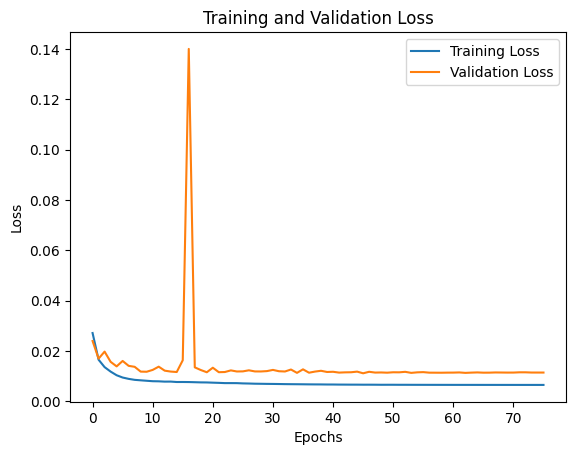

In [3]:
import tensorflow as tf
from keras_tuner import BayesianOptimization
import matplotlib.pyplot as plt
import json
from tensorflow.keras import layers, regularizers
class LNNLayer(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(LNNLayer, self).__init__()
        self.hidden_size = hidden_size
        self.W_in = self.add_weight(
            shape=(input_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg),
            trainable=True
        )
        self.W_rec = self.add_weight(
            shape=(hidden_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg), 
            trainable=True
        )
        self.W_tau = self.add_weight(
            shape=(input_size + hidden_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg),
            trainable=True
        )
        self.activation = tf.nn.tanh
        self.tau_activation = tf.nn.softplus
        self.norm = layers.BatchNormalization()  # 添加归一化层

    def call(self, inputs, state):
        new_state = self.activation(tf.matmul(inputs, self.W_in) + tf.matmul(state, self.W_rec))
        combined = tf.concat([inputs, state], axis=-1)
        tau = self.tau_activation(tf.matmul(combined, self.W_tau))
        state = state + (1.0 / tau) * (new_state - state)
        state = self.norm(state)  # 归一化
        return state

class DynamicTimeConstantGRU(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(DynamicTimeConstantGRU, self).__init__()
        self.hidden_size = hidden_size
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_tau = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_tau = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.b_tau = self.add_weight(shape=(hidden_size,), initializer='zeros', trainable=True)
        self.activation = tf.nn.tanh
        self.sigmoid = tf.nn.sigmoid
        self.tau_activation = tf.nn.softplus
        self.norm = layers.BatchNormalization()  # 添加归一化层

    def call(self, inputs, state):
        r_t = self.sigmoid(tf.matmul(inputs, self.W_r) + tf.matmul(state, self.U_r))
        z_t = self.sigmoid(tf.matmul(inputs, self.W_z) + tf.matmul(state, self.U_z))
        h_tilde = self.activation(tf.matmul(inputs, self.W_h) + r_t * tf.matmul(state, self.U_h))
        tau_t = self.tau_activation(tf.matmul(inputs, self.W_tau) + tf.matmul(state, self.U_tau) + self.b_tau)
        new_state = state + (1.0 / tau_t) * (z_t * (h_tilde - state))
        new_state = self.norm(new_state)  # 归一化
        return new_state
    
class ResidualLNNLayer(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(ResidualLNNLayer, self).__init__()
        self.lnn_layer = LNNLayer(input_size, hidden_size, l2_reg)
        self.norm = layers.BatchNormalization()

    def call(self, inputs, state):
        lnn_output = self.lnn_layer(inputs, state)
        lnn_output = self.norm(lnn_output)
        return layers.add([state, lnn_output])  # 添加残差连接

class ResidualGRULayer(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(ResidualGRULayer, self).__init__()
        self.gru_layer = DynamicTimeConstantGRU(input_size, hidden_size, l2_reg)
        self.norm = layers.BatchNormalization()

    def call(self, inputs, state):
        gru_output = self.gru_layer(inputs, state)
        gru_output = self.norm(gru_output)
        return layers.add([state, gru_output])  # 添加残差连接

class LNNGRUModelWithResiduals(tf.keras.Model):
    def __init__(self, input_size, hidden_size_GRU, hidden_size_LNN, l2_reg, num_residual_blocks, output_size):
        super(LNNGRUModelWithResiduals, self).__init__()
        self.lnn_layer = LNNLayer(input_size, hidden_size_LNN, l2_reg)
        self.dynamic_gru_layer = DynamicTimeConstantGRU(input_size, hidden_size_GRU, l2_reg)
        self.residual_lnn_layers = [ResidualLNNLayer(input_size, hidden_size_LNN, l2_reg) for _ in range(num_residual_blocks)]
        self.residual_gru_layers = [ResidualGRULayer(input_size, hidden_size_GRU, l2_reg) for _ in range(num_residual_blocks)]
        self.fc = layers.Dense(output_size, kernel_regularizer=regularizers.l2(l2_reg))

    def call(self, inputs):
        lnn_state = tf.zeros((tf.shape(inputs)[0], self.lnn_layer.hidden_size))
        gru_state = tf.zeros((tf.shape(inputs)[0], self.dynamic_gru_layer.hidden_size))

        lnn_output = self.lnn_layer(inputs, lnn_state)
        gru_output = self.dynamic_gru_layer(inputs, gru_state)

        for layer in self.residual_lnn_layers:
            lnn_output = layer(inputs, lnn_output)

        for layer in self.residual_gru_layers:
            gru_output = layer(inputs, gru_output)

        combined_output = tf.concat([lnn_output, gru_output], axis=-1)
        output = self.fc(combined_output)
        return output

def build_model(hp):
    input_size = X_train_scaled.shape[1]
    hidden_size_GRU = hp.Int('hidden_size_GRU', min_value=32, max_value=256, step=32)
    hidden_size_RNN = hp.Int('hidden_size_RNN', min_value=32, max_value=256, step=32)
    num_residual_blocks = int(hp.Int('num_residual_blocks', min_value=1, max_value=5, step=1))
    l2_r = hp.Float('L2_regularizer', min_value=1e-4, max_value=1e-2, sampling='LOG')
    output_size = 1
    
    model = LNNGRUModelWithResiduals(input_size, hidden_size_GRU, hidden_size_RNN, l2_r, num_residual_blocks, output_size)
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=30,
    directory='my_dir',
    project_name='TC_GRU_RNN_model_tuning'
)

def scheduler(epoch, lr):
    if epoch < 20:
        return lr  # 直接返回 lr
    else:
        return lr * tf.math.exp(-0.1).numpy()  # 计算新的学习率并转换为浮点数

# 创建 LearningRateScheduler 回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# 创建 EarlyStopping 回调
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 监控验证集损失
    patience=30,         # 在10个epoch后停止，如果val_loss没有改进
    verbose=1,
    restore_best_weights=True  # 恢复最佳模型的权重
)

tuner.search(X_train_scaled, y_train_scaled, epochs=100, validation_data=(X_val_scaled, y_val_scaled), batch_size=64,callbacks=[lr_scheduler, early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps_dict = best_hps.values
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hps_dict, f)

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, validation_data=(X_val_scaled, y_val_scaled), batch_size=64,callbacks=[lr_scheduler, early_stopping])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


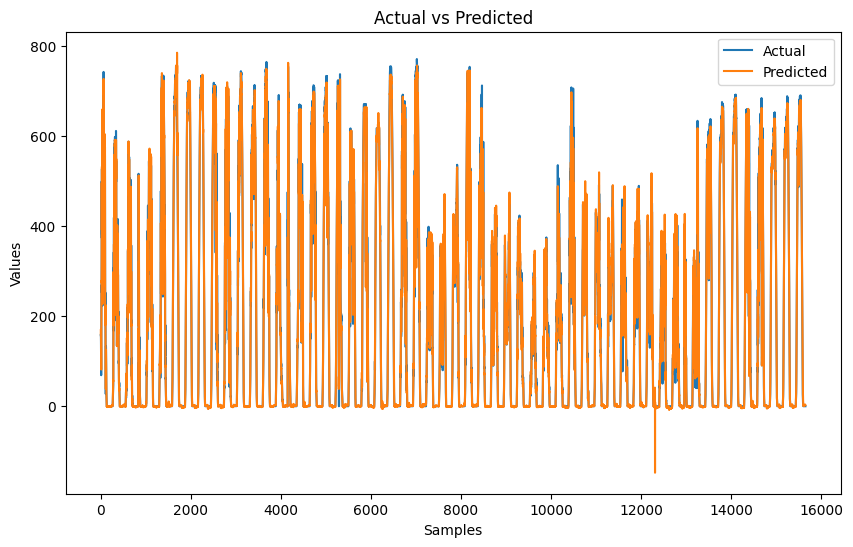

In [4]:
# 测试模型并反归一化
y_pred_lnn_scaled = model.predict(X_test_scaled)
y_pred_lnn = scaler_y.inverse_transform(y_pred_lnn_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# 可视化预测结果与实际值对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_lnn, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

# 加载和使用保存的最佳超参数（如果需要）
# with open('best_hyperparameters.json', 'r') as f:
#     best_hps_dict = json.load(f)
# best_hps = tuner.oracle.hyperparameters.copy()
# for k, v in best_hps_dict.items():
#     best_hps[k] = v
# model = tuner.hypermodel.build(best_hps)